<a href="https://colab.research.google.com/github/nandhana154/karateclub-assignment/blob/main/karateclubfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Spectral Modularity Partitioning on Karate Club Graph ===
Graph has 34 nodes and 78 edges

Iteration 1: 1 communities


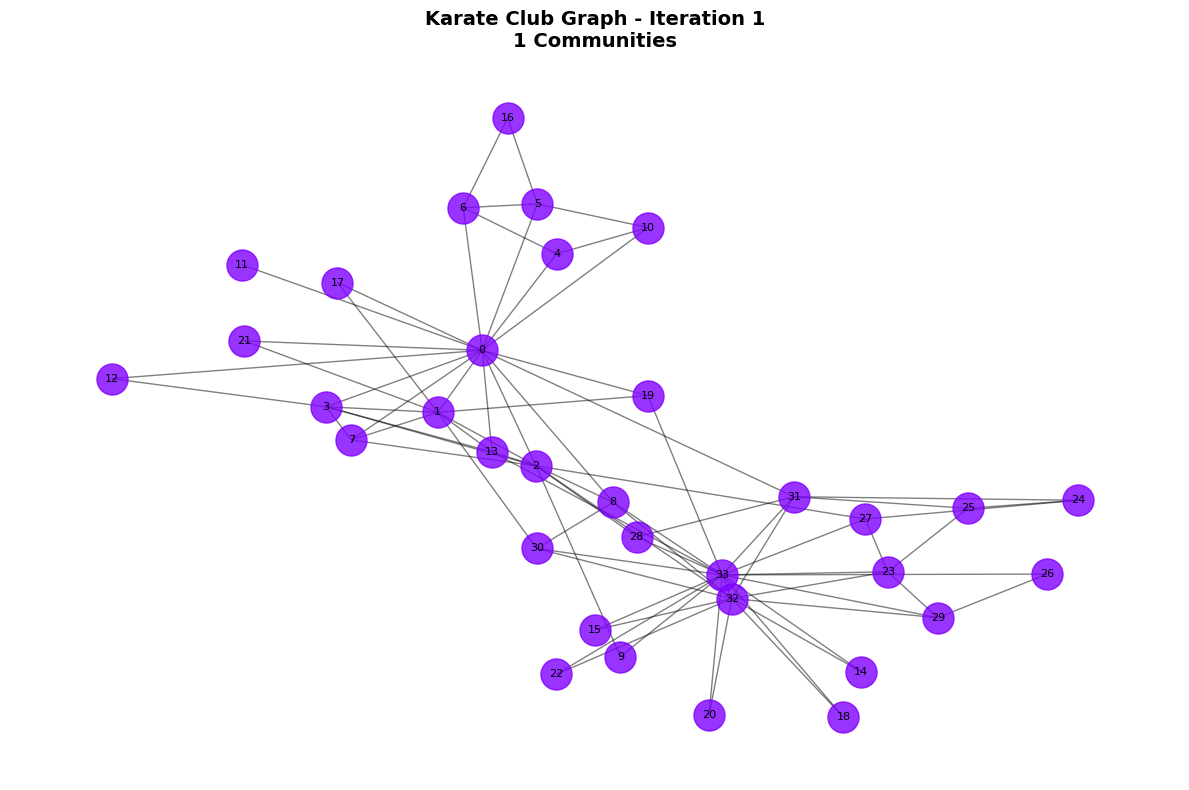

  Split community of size 34 into 18 and 16
Iteration 2: 2 communities


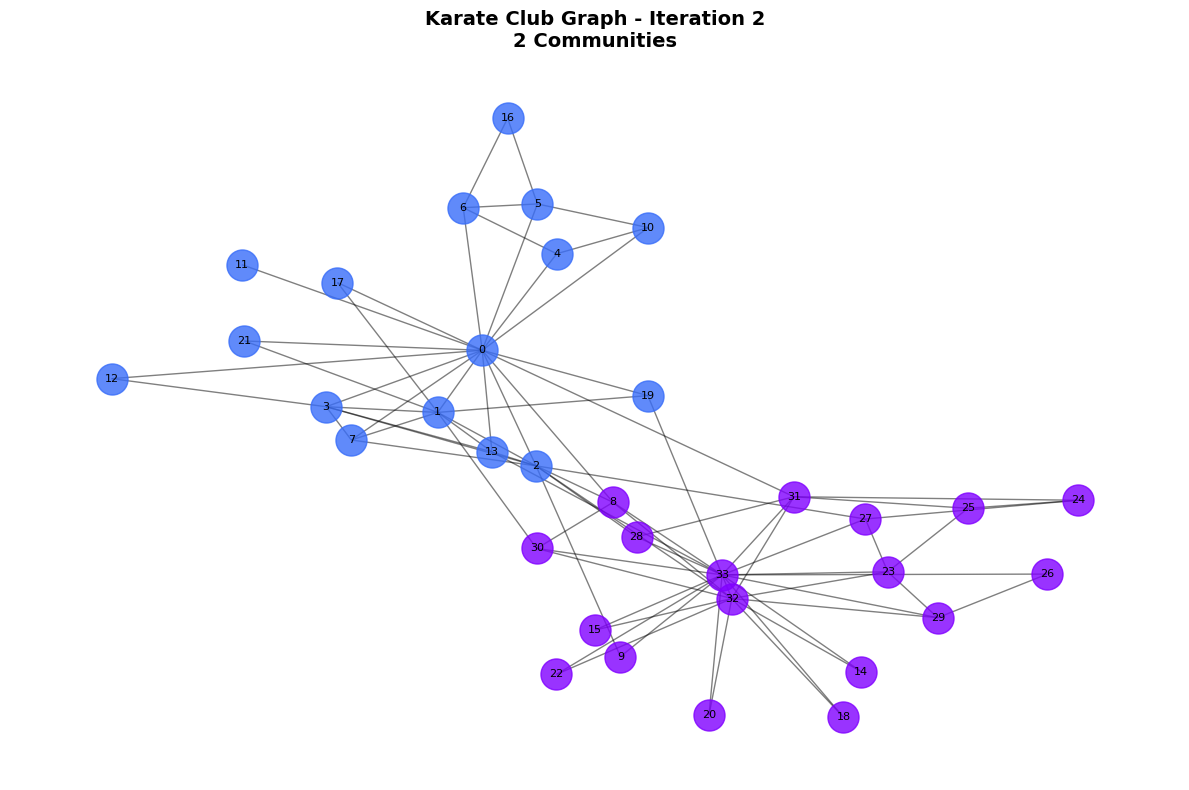

  Split community of size 18 into 12 and 6
  Split community of size 16 into 8 and 8
Iteration 3: 4 communities


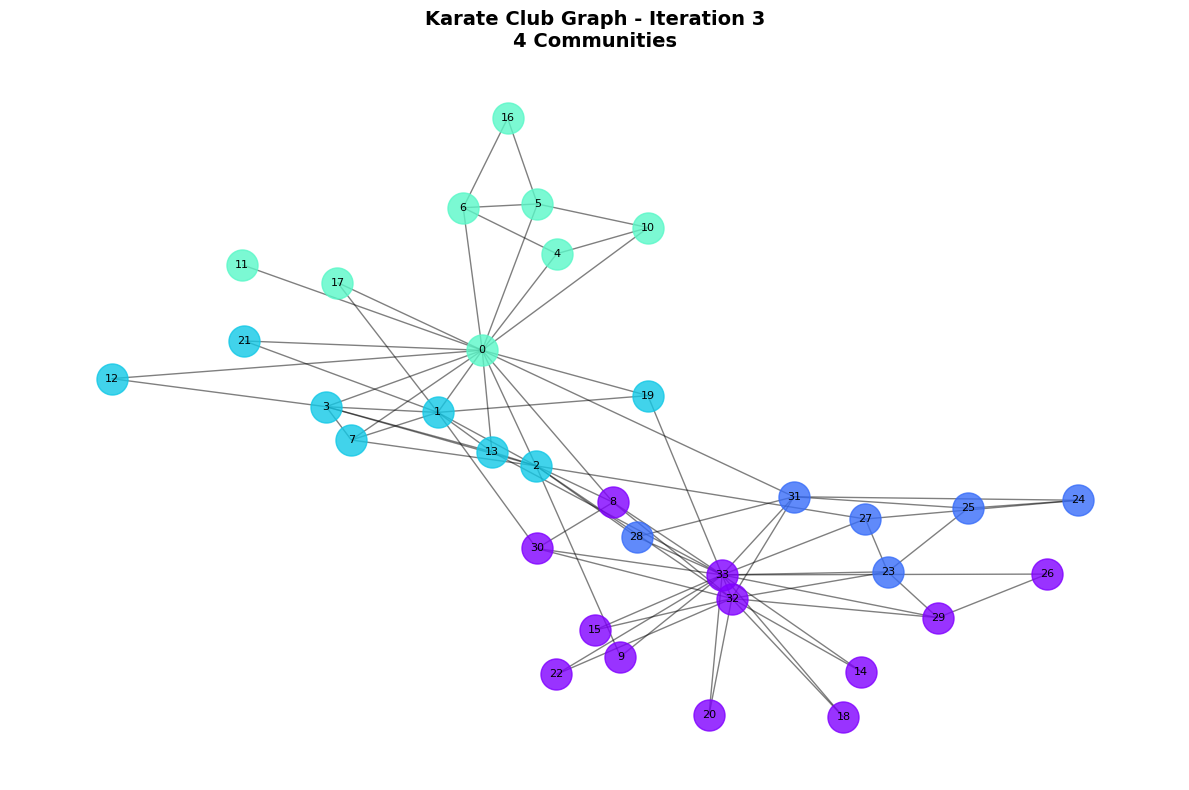

  Split community of size 8 into 4 and 4
  Split community of size 8 into 3 and 5
Iteration 4: 6 communities


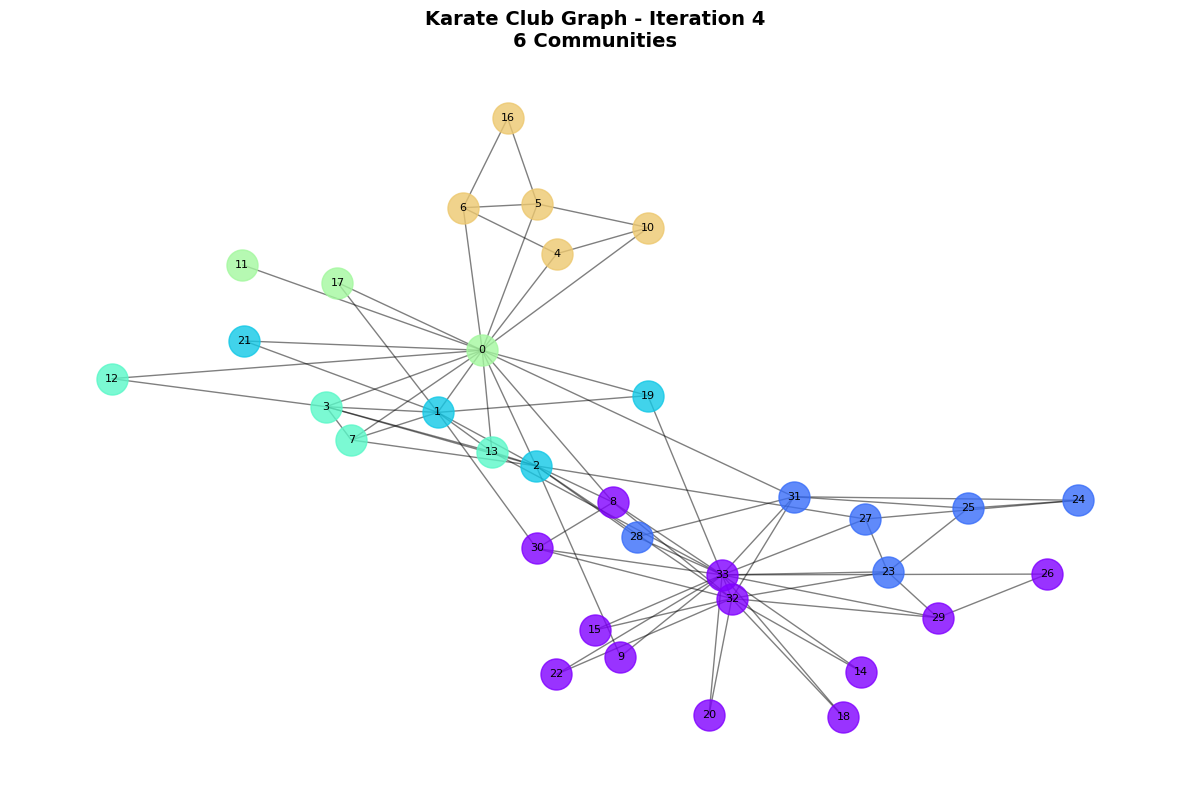

No more splits possible - stopping


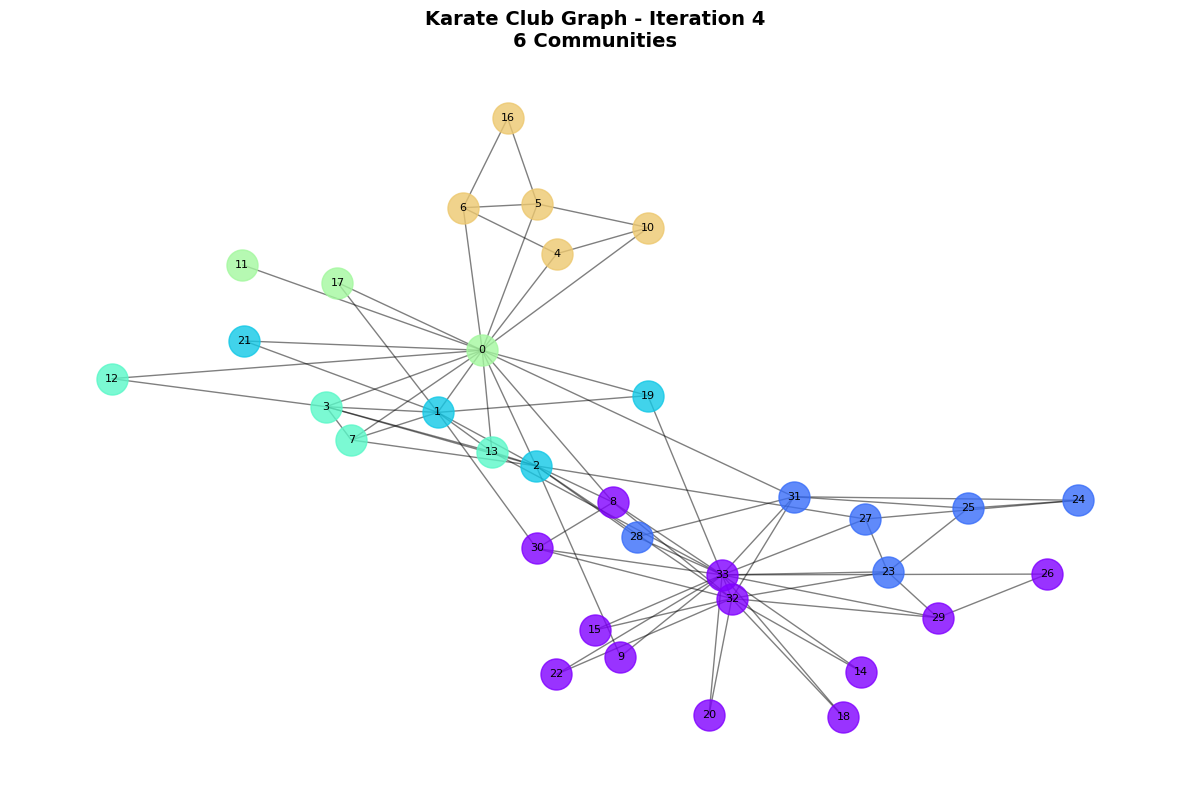


Final result: 6 communities
  Community 1: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33] (size: 12)
  Community 2: [23, 24, 25, 27, 28, 31] (size: 6)
  Community 3: [1, 2, 19, 21] (size: 4)
  Community 4: [3, 7, 12, 13] (size: 4)
  Community 5: [0, 11, 17] (size: 3)
  Community 6: [4, 5, 6, 10, 16] (size: 5)
Final modularity: 0.3400


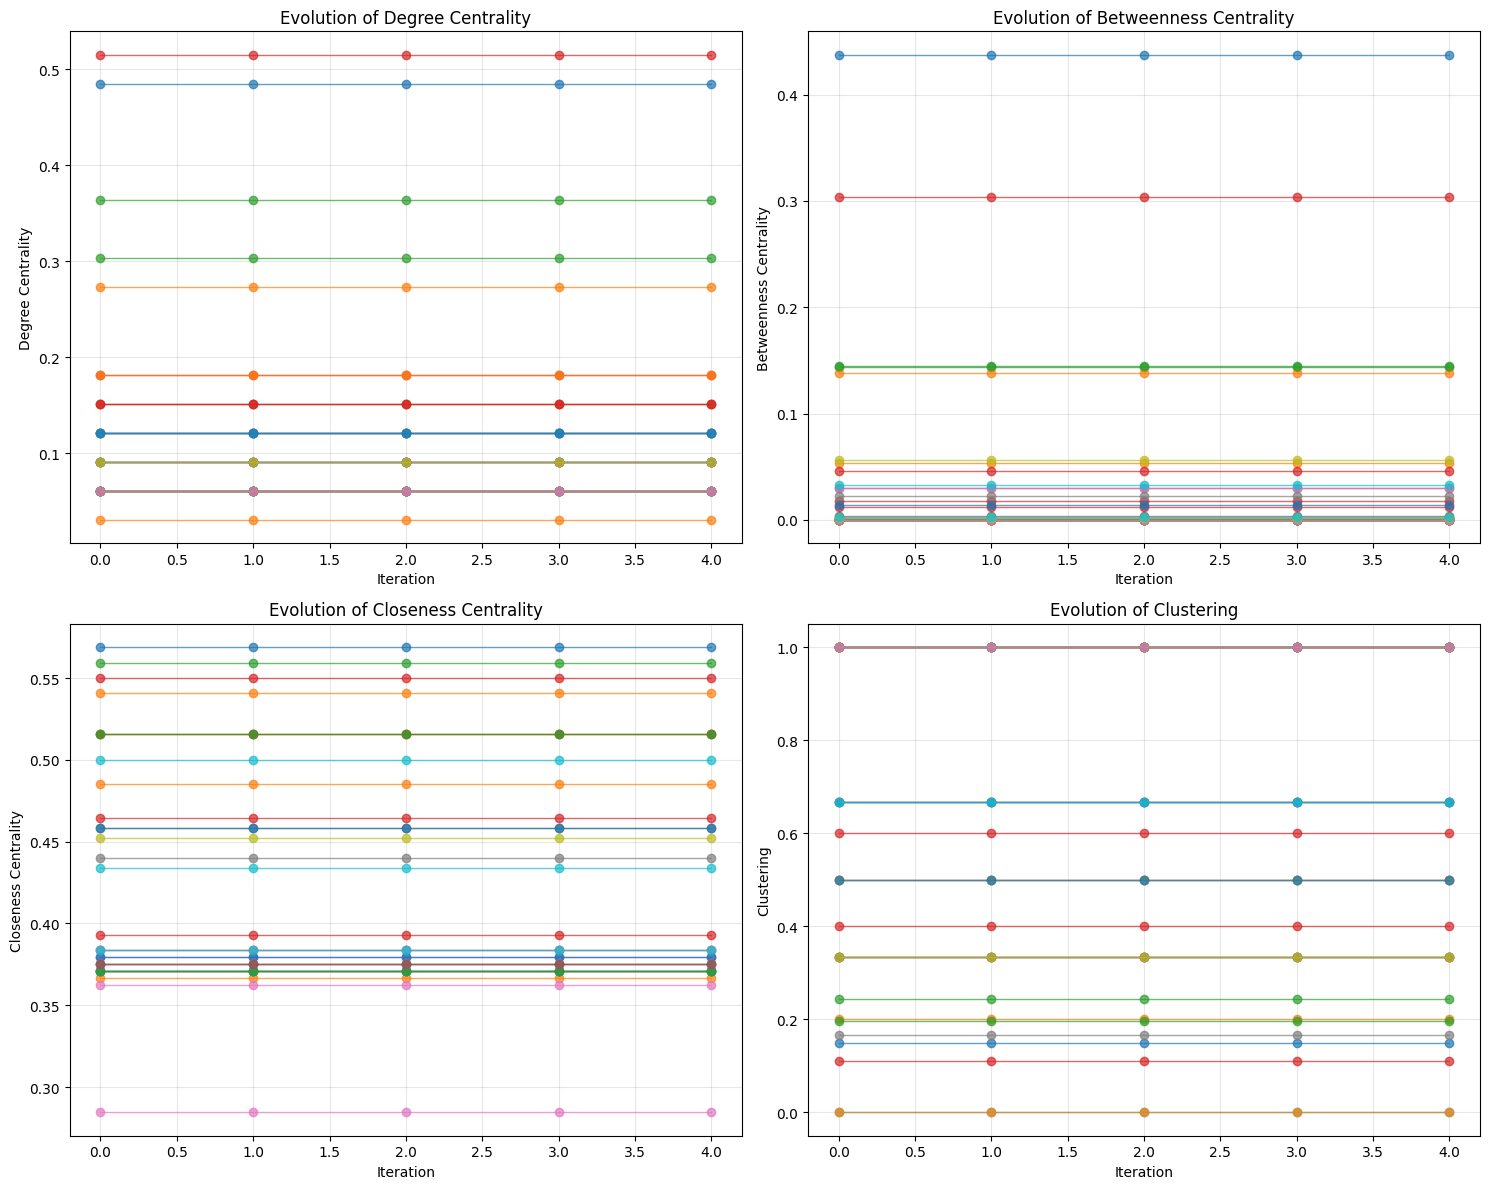


=== Centrality Analysis ===
Most consistently central nodes (lower rank = more central):
  Node 0: average rank 8.75
  Node 2: average rank 9.25
  Node 8: average rank 9.50
  Node 33: average rank 9.50
  Node 13: average rank 9.75
  Node 32: average rank 10.50
  Node 1: average rank 10.75
  Node 3: average rank 10.75
  Node 31: average rank 11.00
  Node 7: average rank 12.75

=== Final Community Structure ===
Total communities: 6

=== Comparison with Ground Truth ===
Ground truth has 2 communities (Mr. Hi vs President)
Algorithm found 6 communities
This shows the natural community structure revealed by modularity optimization


In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import collections

class SpectralModularityPartitioning:
    def __init__(self, G):
        self.G = G
        self.n = G.number_of_nodes()
        self.m = G.number_of_edges()
        self.nodes = list(G.nodes())
        self.node_to_idx = {node: i for i, node in enumerate(self.nodes)}
        self.idx_to_node = {i: node for i, node in enumerate(self.nodes)}

        # Initialize adjacency matrix and degree vector
        self.A = nx.to_numpy_array(G, nodelist=self.nodes)
        self.k = np.sum(self.A, axis=1)

        # Compute global modularity matrix
        self.B_global = self.A - np.outer(self.k, self.k) / (2 * self.m)

        # Storage for results
        self.communities_history = []
        self.metrics_history = []
        self.partition_history = []

    def compute_modularity_matrix(self, nodes_subset):
        """Compute modularity matrix for a subset of nodes"""
        if len(nodes_subset) == 0:
            return np.array([]), []

        # Get indices of nodes in the subset
        indices = [self.node_to_idx[node] for node in nodes_subset]

        # Extract submatrix from global modularity matrix
        B_sub = self.B_global[np.ix_(indices, indices)]

        return B_sub, indices

    def spectral_split(self, nodes_subset):
        """Perform spectral bipartition on a subset of nodes"""
        if len(nodes_subset) <= 3:  # Increased minimum size to prevent small splits
            return None, None, 0

        B_sub, indices = self.compute_modularity_matrix(nodes_subset)

        if B_sub.size == 0:
            return None, None, 0

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(B_sub)

        # Get leading eigenvector (largest eigenvalue)
        leading_idx = np.argmax(eigenvalues)
        lambda1 = eigenvalues[leading_idx]
        u1 = eigenvectors[:, leading_idx]

        # More conservative threshold for splitting
        if lambda1 <= 0.1:  # Increased threshold from 0 to 0.1
            return None, None, lambda1

        # Split based on sign of leading eigenvector
        community1 = [nodes_subset[i] for i in range(len(nodes_subset)) if u1[i] > 0]
        community2 = [nodes_subset[i] for i in range(len(nodes_subset)) if u1[i] <= 0]

        # Ensure we don't get empty communities and both communities are reasonably sized
        if len(community1) == 0 or len(community2) == 0:
            return None, None, lambda1

        # Ensure both resulting communities have at least 3 nodes
        if len(community1) < 3 or len(community2) < 3:
            return None, None, lambda1

        return community1, community2, lambda1

    def compute_network_metrics(self, communities):
        """Compute network metrics for current community structure"""
        # Create a copy of the graph for metric computation
        G_copy = self.G.copy()

        # Assign community labels to nodes
        community_labels = {}
        for comm_id, comm_nodes in enumerate(communities):
            for node in comm_nodes:
                community_labels[node] = comm_id

        nx.set_node_attributes(G_copy, community_labels, 'community')

        metrics = {
            'degree_centrality': nx.degree_centrality(G_copy),
            'betweenness_centrality': nx.betweenness_centrality(G_copy),
            'closeness_centrality': nx.closeness_centrality(G_copy),
            'clustering': nx.clustering(G_copy)
        }

        return metrics

    def run_analysis(self, max_iterations=6):  # Reduced max iterations
        """Run the complete analysis with visualization and metrics tracking"""
        # Initial state - all nodes in one community
        current_communities = [self.nodes]

        # Fixed layout for consistent visualization
        pos = nx.spring_layout(self.G, seed=42)

        # Color map for communities
        colors = cm.rainbow(np.linspace(0, 1, 8))  # Reduced color range

        iteration = 0

        while iteration < max_iterations:
            print(f"Iteration {iteration + 1}: {len(current_communities)} communities")

            # Store current state
            self.communities_history.append(current_communities.copy())
            self.partition_history.append(self.get_partition_dict(current_communities))

            # Compute and store metrics
            metrics = self.compute_network_metrics(current_communities)
            self.metrics_history.append(metrics)

            # Visualize current partition
            self.visualize_communities(current_communities, pos, colors, iteration + 1)

            # Try to split each community
            new_communities = []
            changed = False

            for community in current_communities:
                # More conservative: only split larger communities
                if len(community) <= 5:  # Increased minimum size for splitting
                    new_communities.append(community)
                    continue

                comm1, comm2, lambda1 = self.spectral_split(community)

                if comm1 is not None and lambda1 > 0.1:  # More conservative threshold
                    new_communities.extend([comm1, comm2])
                    changed = True
                    print(f"  Split community of size {len(community)} into {len(comm1)} and {len(comm2)}")
                else:
                    new_communities.append(community)

            if not changed:  # No more splits possible
                print("No more splits possible - stopping")
                break

            current_communities = new_communities
            iteration += 1

        # Final state
        self.communities_history.append(current_communities)
        self.partition_history.append(self.get_partition_dict(current_communities))
        metrics = self.compute_network_metrics(current_communities)
        self.metrics_history.append(metrics)
        self.visualize_communities(current_communities, pos, colors, iteration + 1)

        print(f"\nFinal result: {len(current_communities)} communities")
        for i, comm in enumerate(current_communities):
            print(f"  Community {i+1}: {sorted(comm)} (size: {len(comm)})")

        # Calculate final modularity
        final_modularity = nx.algorithms.community.modularity(
            self.G, [set(comm) for comm in current_communities]
        )
        print(f"Final modularity: {final_modularity:.4f}")

    def get_partition_dict(self, communities):
        """Convert community list to node->community dictionary"""
        partition = {}
        for comm_id, comm_nodes in enumerate(communities):
            for node in comm_nodes:
                partition[node] = comm_id
        return partition

    def visualize_communities(self, communities, pos, colors, iteration):
        """Visualize the graph with community coloring"""
        plt.figure(figsize=(12, 8))

        partition = self.get_partition_dict(communities)

        # Draw nodes with community colors
        for comm_id, comm_nodes in enumerate(communities):
            nx.draw_networkx_nodes(self.G, pos,
                                 nodelist=comm_nodes,
                                 node_color=[colors[comm_id % len(colors)]],
                                 node_size=500,
                                 alpha=0.8)

        # Draw edges
        nx.draw_networkx_edges(self.G, pos, alpha=0.5)

        # Draw labels
        labels = {node: str(node) for node in self.G.nodes()}
        nx.draw_networkx_labels(self.G, pos, labels, font_size=8)

        plt.title(f'Karate Club Graph - Iteration {iteration}\n{len(communities)} Communities',
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def plot_metrics_evolution(self):
        """Plot the evolution of network metrics across iterations"""
        if len(self.metrics_history) < 2:
            print("Not enough iterations to plot evolution")
            return

        metrics_names = ['degree_centrality', 'betweenness_centrality',
                        'closeness_centrality', 'clustering']
        n_metrics = len(metrics_names)

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        # Get all nodes for consistent ordering
        all_nodes = sorted(self.G.nodes())

        for idx, metric_name in enumerate(metrics_names):
            ax = axes[idx]

            # Prepare data for plotting
            iterations = range(len(self.metrics_history))
            metric_data = []

            for node in all_nodes:
                node_values = []
                for metrics in self.metrics_history:
                    node_values.append(metrics[metric_name][node])
                metric_data.append(node_values)

            # Plot each node's metric evolution
            for i, node_vals in enumerate(metric_data):
                ax.plot(iterations, node_vals, marker='o', label=f'Node {all_nodes[i]}',
                       alpha=0.7, linewidth=1)

            ax.set_xlabel('Iteration')
            ax.set_ylabel(f'{metric_name.replace("_", " ").title()}')
            ax.set_title(f'Evolution of {metric_name.replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)

            # Add legend for a subset of nodes to avoid clutter
            if len(all_nodes) <= 10:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def analyze_central_nodes(self):
        """Analyze which nodes remain central across splits"""
        if len(self.metrics_history) < 2:
            print("Not enough iterations for analysis")
            return

        metrics_names = ['degree_centrality', 'betweenness_centrality',
                        'closeness_centrality', 'clustering']

        # Calculate average rank for each node across iterations
        node_ranks = {node: [] for node in self.G.nodes()}

        for metrics in self.metrics_history:
            for metric_name in metrics_names:
                metric_values = metrics[metric_name]
                # Rank nodes for this metric (higher value = better rank)
                sorted_nodes = sorted(metric_values.items(), key=lambda x: x[1], reverse=True)
                ranks = {node: rank for rank, (node, _) in enumerate(sorted_nodes, 1)}

                for node in self.G.nodes():
                    node_ranks[node].append(ranks[node])

        # Calculate average rank for each node
        avg_ranks = {}
        for node, ranks in node_ranks.items():
            avg_ranks[node] = np.mean(ranks)

        # Identify consistently central nodes (low average rank = high centrality)
        central_nodes = sorted(avg_ranks.items(), key=lambda x: x[1])

        print("\n=== Centrality Analysis ===")
        print("Most consistently central nodes (lower rank = more central):")
        for node, avg_rank in central_nodes[:10]:
            print(f"  Node {node}: average rank {avg_rank:.2f}")

        return central_nodes

# Load the Karate Club graph
G = nx.karate_club_graph()

# Run the analysis
print("=== Spectral Modularity Partitioning on Karate Club Graph ===")
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n")

analyzer = SpectralModularityPartitioning(G)
analyzer.run_analysis(max_iterations=6)

# Plot metrics evolution
analyzer.plot_metrics_evolution()

# Analyze central nodes
central_nodes = analyzer.analyze_central_nodes()

# Final community analysis
final_communities = analyzer.communities_history[-1]
print(f"\n=== Final Community Structure ===")
print(f"Total communities: {len(final_communities)}")

# Compare with ground truth
ground_truth = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 10: 0, 11: 0, 12: 0, 13: 0, 16: 0, 17: 0, 19: 0, 21: 0,
    33: 1, 23: 1, 24: 1, 25: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 9: 1, 14: 1, 15: 1, 18: 1, 20: 1, 22: 1, 26: 1
}

print(f"\n=== Comparison with Ground Truth ===")
print("Ground truth has 2 communities (Mr. Hi vs President)")
print(f"Algorithm found {len(final_communities)} communities")
print("This shows the natural community structure revealed by modularity optimization")